# Spatial Inversion of dv/v
SeisMIC can invert dv/v time series from several station combination onto a spatial grid using the method proposed by Obermann, et al. (2013). This method is based on 2D sensitivity kernels that arise from the time-dependent solution of the Boltzmann equation for a homogeneous medium (see Paasschens, 1997).
A demonstration with real data would require a bit too much download and a very dense network.

So for this demonstration we commit a little inversion crime and try to re-obtain a velocity change model that is already known to us.

## Define the parameters
We use the class `seismic.monitor.spatial.DVGrid` to initialise an empty grid, for which we compute the sensitivity kernels, the forward model, and the inverse model.

In [118]:
from seismic.monitor.spatial import DVGrid

# For convenience, we define the map at the equator
lat0 = lon0 = 0  # lower left corner

# Y- and X-extent in km
y = x = 40
res = 1  # resolution in km
vel = 3  # wave velocity km/s
mf_path = 30  # mean free path in km, dependent on the geology
dt = 0.05  # Sampling interval to compute the sensitivity kernels
# dt should be larger than res/vel. If not, the kernels will be aliased.
# Small dt makes a smoother kernel, but the computation takes longer.

# Initialise the grid
dvg = DVGrid(lat0, lon0, res, x, y, dt, vel, mf_path)

## Create a synthetic velocity grid

Text(0.5, 1.0, 'Synthetic Velocity-Change Model')

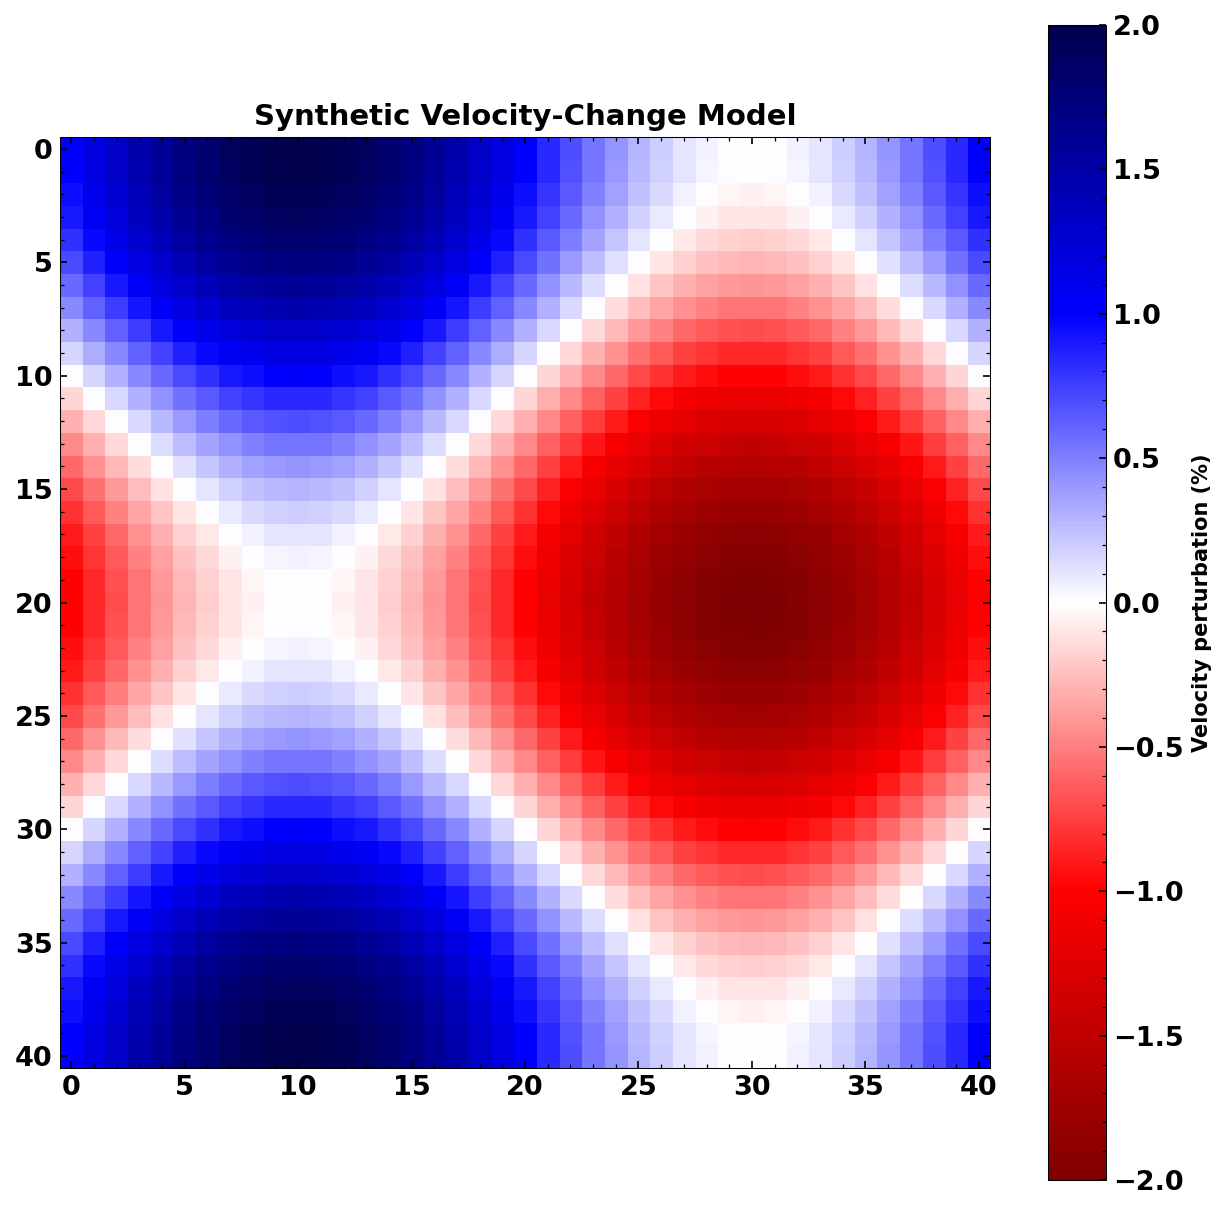

In [119]:
import numpy as np
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from seismic.plot.plot_utils import set_mpl_params

chkb = np.zeros_like(dvg.xgrid)
for ii, yy in enumerate(np.arange(y/res+1)):
    chkb[ii, :] = np.sin(
        2*np.pi*np.arange(x/res+1)/(x/res)) + np.cos(2*np.pi*yy/(y/res))
chkb /= 100

# Plot the synthetic checkerboard
set_mpl_params()
plt.figure(figsize=(10, 10))
plt.imshow(chkb*100, cmap='seismic_r')
plt.colorbar(label='Velocity perturbation (%)')
plt.title('Synthetic Velocity-Change Model')

## Define station locations and compute dv/v values for each combination

Now we will place stations randomly onto our grid and use a forward modelling approach to
compute the velocity change that would be sensed between each station pair (i.e., now we will look at "cross-correlations").

Feel free to change the number of stations `nsta` to see by how much we can increase the accuracy of our inversion result.

In [120]:

from seismic.monitor.dv import DV
from seismic.correlate.stats import CorrStats

### parameters ###
#  #### You can play with these parameters to see how it affects the result
nsta = 10  # number of stations, increases computation time

# lapse time parameters in s
# don't set these to small (have to contain the ballistic wave arriving
# with the velocity of the medium)
tw_start = 0
tw_len = 100

# frequency band
freq_min = .5
freq_max = 1.5

# Should the lapse time window be split up into several subwindows
# Note that this could increase the spatial sensitivity. But obviously
# also increases the computation time
n_split = 11  # if n_split > 1, tw_len has to be divided by n_split

use_auto_correlations = True  # use auto correlations
use_cross_correlations = True  # use cross correlations

#  #### end of parameters ####


# #### actual code ####
# distribute stations randomly
np.random.seed(1234)
sta_x = np.random.random(nsta)*x
sta_y = np.random.random(nsta)*y

# convert into lat/lon not 100% but good enough as close to equator
sta_lon = sta_x/111.19492664455873
sta_lat = sta_y/111.19492664455873

dvs = []
tw_len = tw_len//n_split
for slat0, slon0 in zip(sta_lat, sta_lon):
    for slat1, slon1 in zip(sta_lat, sta_lon):
        if slat0 == slat1 and slon0 == slon1 and not use_auto_correlations:
            # we don't want auto correlations
            continue
        if any(
            [slat0 != slat1, slon0 != slon1])\
                and not use_cross_correlations:
            # we don't want cross correlations
            continue

        # create dv.stats
        cst = CorrStats(
            {
                'stla': slat0, 'stlo': slon0, 'evla': slat1, 'evlo': slon1,
                'corr_start': np.array(
                    [UTCDateTime(ii*3600) for ii in np.arange(35)]),
                'corr_end': np.array(
                    [UTCDateTime((ii+1)*3600) for ii in np.arange(35)])})
        for ii in range(n_split):
            dv = DV(
                .9*np.ones((35, )), np.ones((35, )), 'stretch', None,
                None, 'modelled', cst,
                dv_processing={
                    'tw_start': tw_start + ii*tw_len, 'tw_len': tw_len,
                    'freq_min': freq_min, 'freq_max': freq_max})
            dvs.append(dv)

### Forward modelling
Depending on your choice of parameters, this could take a little while.
This will compute and cache the sensitivity kernels, so if you add more stations
to the list afterwards, only new sensitivity kernels will be computed. All the parameters
will be extracted from the `DV` objects.

In [121]:
fwd_model = dvg.forward_model(
    chkb, dvs=dvs, utc=dvs[0].stats.corr_start[5])

### add random noise
add random noise to the forward model. You can play with the amplitude here

In [154]:
# set noise amplitude (relative to the signal)
noise_amp = .3

# add noise
# assign values. Technicall we should only set the value at index 5
# but it doesn't really matter so much
for dv, fwd_val in zip(dvs, fwd_model):
    dv.value[:] = fwd_val
    dv.value += np.random.randn(len(dv.value))*noise_amp*dv.value

### plot a sensitivity kernel
Let's have a look at one of the kernels



Text(0.5, 0.92, 'An arbitrary sensitivity kernel')

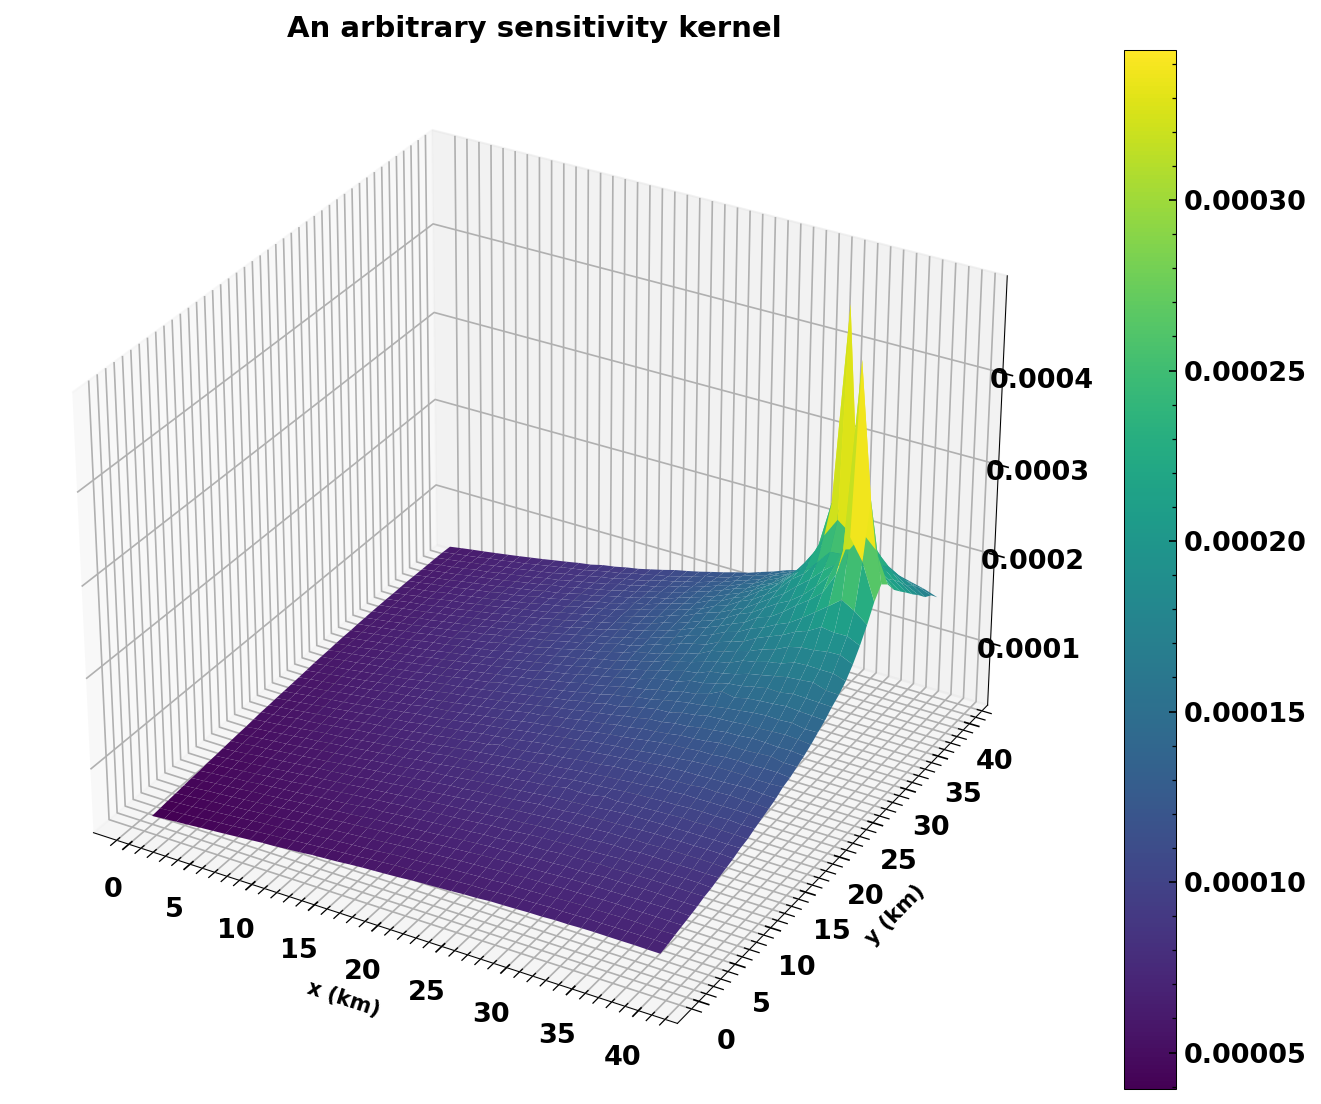

In [155]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 9))
surf = ax.plot_surface(dvg.xgrid, dvg.ygrid, np.reshape(list(dvg.skernels.values())[-2], dvg.xgrid.shape), linewidth=0, antialiased=True, cmap='viridis')
plt.colorbar(surf);
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('An arbitrary sensitivity kernel')

## Compute inverse model
For the inverse model, we will have to set damping parameters. These parameters
are the `corr_len` that basically smoothes the final grid output to avoid sparsities.
And `std_model`, which sets the allowed standard deviation of the output model (i.e.,
limits the search radius around a starting model=0). See Obermann et a., 2013 for details.

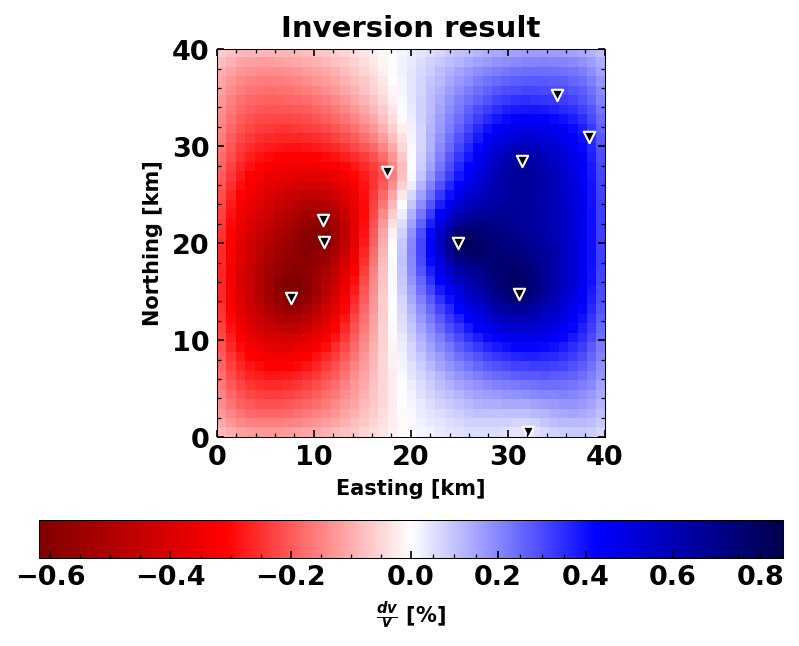

In [156]:
# smoothing parameters
corr_len = 2  # correlation length in km
std_model = 0.32  # standard deviation of the model

inverse_model = dvg.compute_dv_grid(
    dvs, dvs[0].stats.corr_start[5], scaling_factor=res, corr_len=corr_len,
    std_model=std_model)

# Let's have a first look at the result
dvg.plot()
plt.title('Inversion result');

### Plot a comparison between synthetic and inverse


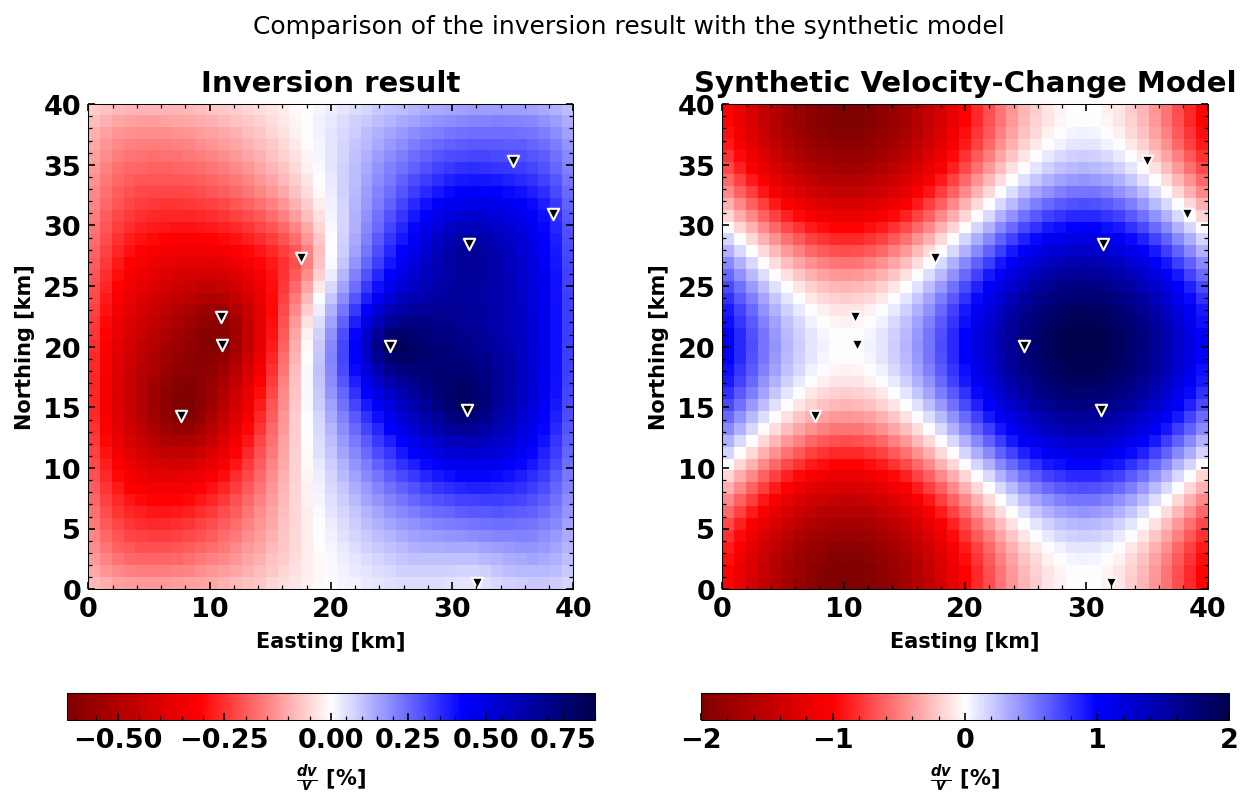

In [157]:
set_mpl_params()

plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 2, 1)

dvg.plot(ax=ax1)
ax2 = plt.subplot(1, 2, 2, sharey=ax1)

# norm = mpl.colors.TwoSlopeNorm(vcenter=0)
map2 = ax2.imshow(
    -np.flipud(chkb)*100, cmap='seismic_r',
    extent=[dvg.xaxis.min(), dvg.xaxis.max(), dvg.yaxis.min(), dvg.yaxis.max()]);
plt.scatter(dvg.statx, dvg.staty, s=30, c='k', edgecolors='white', marker='v')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
plt.colorbar(map2, orientation='horizontal', label=r'$\frac{dv}{v}$ [%]')

ax1.set_title('Inversion result');
ax2.set_title('Synthetic Velocity-Change Model');

plt.suptitle('Comparison of the inversion result with the synthetic model');

# References
[Obermann, A., Planès, T., Larose, E., and Campillo, M. (2013), Imaging preeruptive and coeruptive structural and mechanical changes of a volcano with ambient seismic noise, J. Geophys. Res. Solid Earth, 118, 6285– 6294.](https://doi.org/10.1002/2013JB010399)

[Paasschens, J. C. J. "Solution of the time-dependent Boltzmann equation." Physical Review E 56.1 (1997): 1135.](https://doi.org/10.1103/PhysRevE.56.1135)